# <center><font color=maroon>CPE4903 Project: Cats and Dogs Classifier</font> </center>

### In this mini-project, you will develop a CNN model for the cat-and-dog classifer. 
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance. 

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model.  
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 85% for at least one of your models </font>
* You will save the parameters of the model at the end, which will be deployed on Raspberry Pi.

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each) 
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 6,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 200px;"/> 

### Load tool modules

In [1]:
#!pip install tensorflow[and-cuda]


In [1]:
import os, itertools 
import time
import random, shutil
import numpy as np 
import pandas as pd 
 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'true'

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow import keras

### Load CNN models

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

### Load the image processing tools 

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

### Display 2 input images: one for dog, and one for cat 

In [7]:
# Source directory containing all images
source_dir = "./train"

# Destination directory where you want to save the subset
train_sub_path = './cat_dog_6000'

# Create the subset directory if it doesn't exist
os.makedirs(train_sub_path, exist_ok=True)


In [8]:
def make_subset (subset_name, st_index, end_index):
    for category in ("cat", "dog"):
        dest = train_sub_path + '/' + subset_name + '/' + category
        os.makedirs(dest, exist_ok=True)
        
        files = [f"{category}.{i}.jpg" for i in range(st_index, end_index)]  # list of catxxx.jpg, dogxxx.jpg
        for f in files:
            shutil.copy(src=source_dir + '/' + f, dst=dest + '/ '+ f)

In [9]:
make_subset("train", st_index=0, end_index=3600)
make_subset("validation", st_index=3600, end_index=4500)
make_subset("test", st_index=4500, end_index=6000)

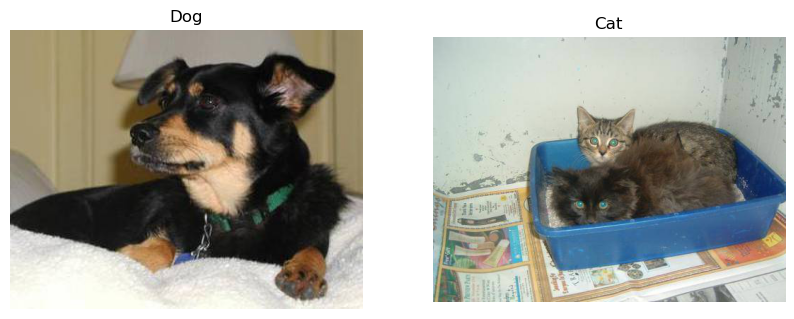

In [10]:

# Load a random image of a dog
dog_directory = os.path.join(train_sub_path, 'test', 'dog')
dog_images = os.listdir(dog_directory)
random_dog_image = random.choice(dog_images)
dog_img = load_img(os.path.join(dog_directory, random_dog_image))

# Load a random image of a cat
cat_directory = os.path.join(train_sub_path, 'test', 'cat')
cat_images = os.listdir(cat_directory)
random_cat_image = random.choice(cat_images)
cat_img = load_img(os.path.join(cat_directory, random_cat_image))

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Dog')
plt.imshow(dog_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Cat')
plt.imshow(cat_img)
plt.axis('off')

plt.show()


In [11]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = datagen.flow_from_directory(train_sub_path + '/train',
            class_mode='binary', batch_size=64, target_size=(64, 64))

val_data = datagen.flow_from_directory(train_sub_path + '/validation',
           class_mode='binary', batch_size=64, target_size=(64, 64))

test_data = datagen.flow_from_directory(train_sub_path + '/test',
            class_mode='binary', batch_size=64, target_size=(64, 64))

Found 7200 images belonging to 2 classes.
Found 2800 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# <font color=blue>Build CNN Model One</font>

In [12]:
#vgg-5 mdoel with increased dataset comapred to example


## <font color=green>Define the CNN model</font> 

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [13]:
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# FC Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


### Print the model summary that shows the output shape and # of parameters for each layer.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

### <font color=red>Question: What are the total number of parameters for the model?</font>

In [15]:
#683329 total parameters per model.summary()

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [16]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=20, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/20
113/113 [==============================] - 60s 522ms/step - loss: 0.6709 - accuracy: 0.5735 - val_loss: 0.6137 - val_accuracy: 0.6493
Epoch 2/20
113/113 [==============================] - 23s 205ms/step - loss: 0.5974 - accuracy: 0.6799 - val_loss: 0.5551 - val_accuracy: 0.7325
Epoch 3/20
113/113 [==============================] - 23s 200ms/step - loss: 0.5404 - accuracy: 0.7262 - val_loss: 0.5989 - val_accuracy: 0.6718
Epoch 4/20
113/113 [==============================] - 22s 196ms/step - loss: 0.4960 - accuracy: 0.7558 - val_loss: 0.4807 - val_accuracy: 0.7743
Epoch 5/20
113/113 [==============================] - 23s 204ms/step - loss: 0.4429 - accuracy: 0.7937 - val_loss: 0.4629 - val_accuracy: 0.7846
Epoch 6/20
113/113 [==============================] - 23s 203ms/step - loss: 0.4192 - accuracy: 0.8079 - val_loss: 0.4316 - val_accuracy: 0.8043
Epoch 7/20
113/113 [==============================] - 23s 204ms/step - loss: 0.3898 - accuracy: 0.8183 - val_loss: 0.4764 - val_ac

### <font color=red>Question: What is the estimated total model training time?</font>

In [18]:
#about 6:05 min

### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

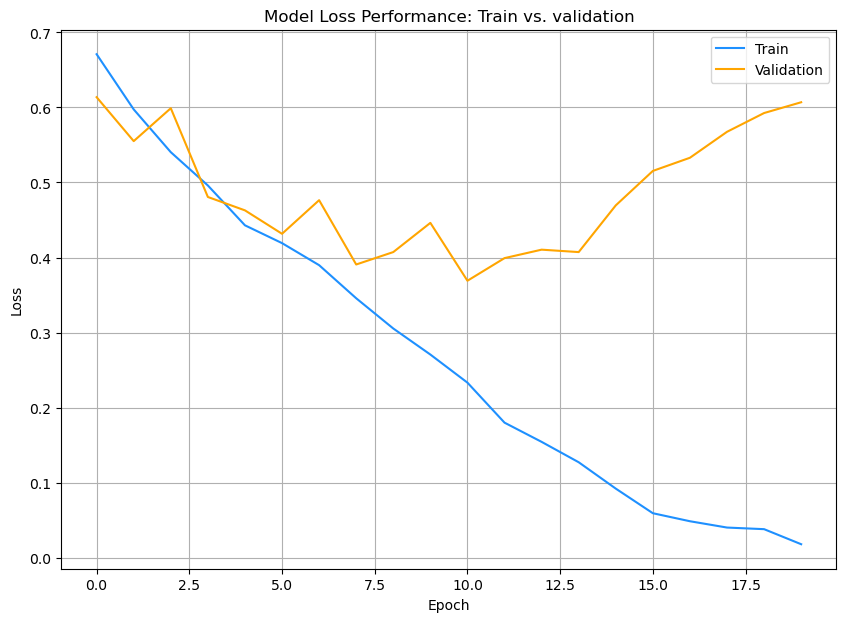

In [19]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

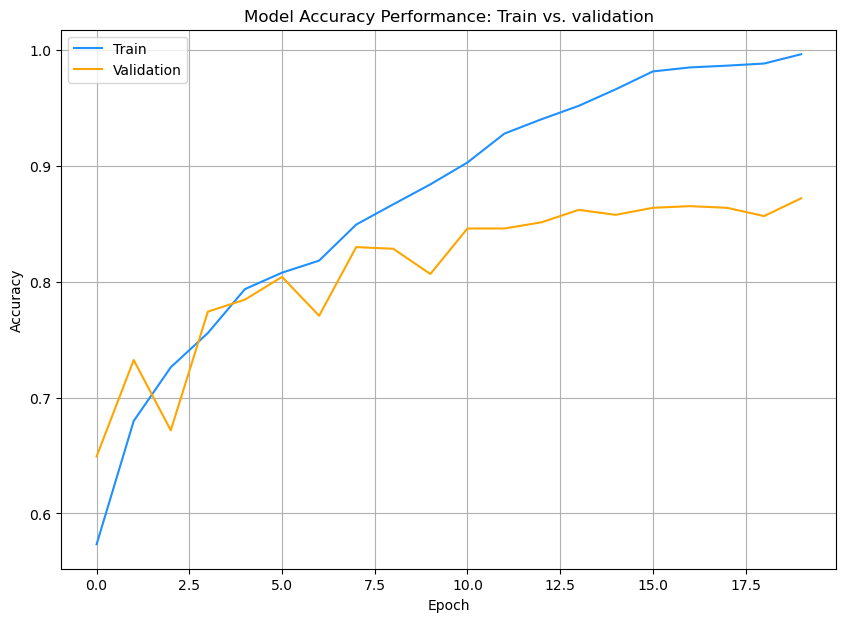

In [20]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

In [21]:
loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

79/79 [==============================] - 9s 110ms/step


### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

### Print the final loss and accuracy of the test data

In [22]:
loss, accuracy


(0.5662366151809692, 0.8763999938964844)

### Save the CNN model parameters

In [25]:
model.save('final.h5')

# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [26]:
from keras.applications.vgg16 import VGG16

## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy | Number of Parameters | Training Time | Inference Speed |
|-------------------- |----------|-----------------------|--------------- |------------------|
| VGG-5  3000 dataset |   75.85%  | 683329                |    4:03min     |  20sec           |
| VGG-5 6000 dataset |   88.3%    | 683329                |   5:05min      |   27sec          |
 VGG-16 6000 dataset  |   87.5%   |  14977089             |    17:09min    |    63 sec        |
| Model Three         |          |                       |                |                  |


__You can also add comments on what you tried and observed while working on the project.__

In [27]:
# Load the VGG-16 model with pre-trained weights on ImageNet

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))    # include_top=False: FC layers are NOT frozen

# Freeze the convolutional layers

for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the VGG-16 base model

model = Sequential()
model.add(base_model)

model.add(Flatten())

# FC Layers for new classifier

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>

In [31]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [29]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14977089 (57.13 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [30]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=10, validation_data = val_data, verbose=1)

Epoch 1/10
113/113 [==============================] - 49s 429ms/step - loss: 0.4857 - accuracy: 0.7618 - val_loss: 0.4268 - val_accuracy: 0.8039
Epoch 2/10
113/113 [==============================] - 56s 495ms/step - loss: 0.4122 - accuracy: 0.8056 - val_loss: 0.4016 - val_accuracy: 0.8100
Epoch 3/10
113/113 [==============================] - 61s 542ms/step - loss: 0.3866 - accuracy: 0.8254 - val_loss: 0.4271 - val_accuracy: 0.8075
Epoch 4/10
113/113 [==============================] - 62s 553ms/step - loss: 0.3568 - accuracy: 0.8468 - val_loss: 0.3820 - val_accuracy: 0.8289
Epoch 5/10
113/113 [==============================] - 62s 547ms/step - loss: 0.3266 - accuracy: 0.8601 - val_loss: 0.3765 - val_accuracy: 0.8318
Epoch 6/10
113/113 [==============================] - 61s 540ms/step - loss: 0.3119 - accuracy: 0.8599 - val_loss: 0.3825 - val_accuracy: 0.8286
Epoch 7/10
113/113 [==============================] - 61s 540ms/step - loss: 0.2901 - accuracy: 0.8763 - val_loss: 0.3935 - val_ac

In [31]:
# 17:09 time to train

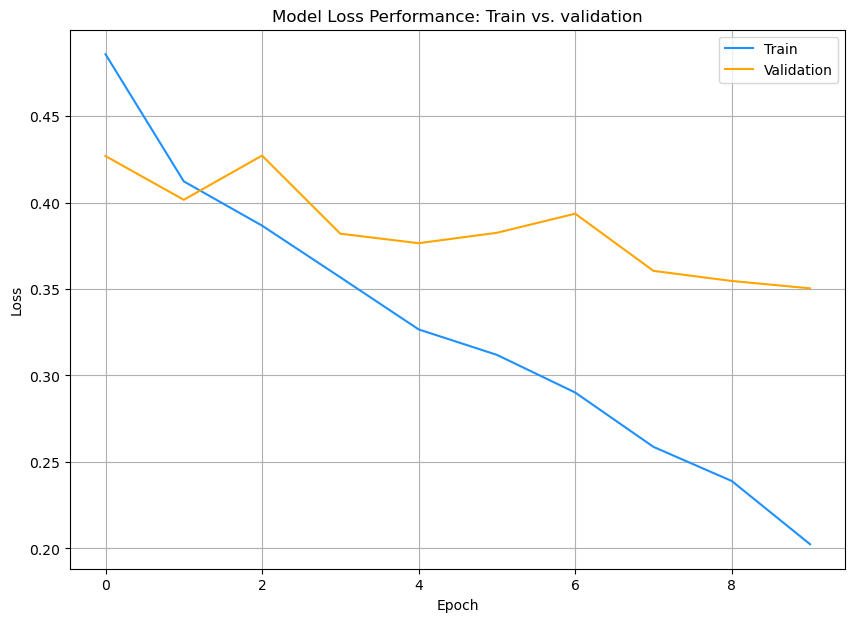

In [32]:
J = history.history['loss']  # Loss data for Training
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

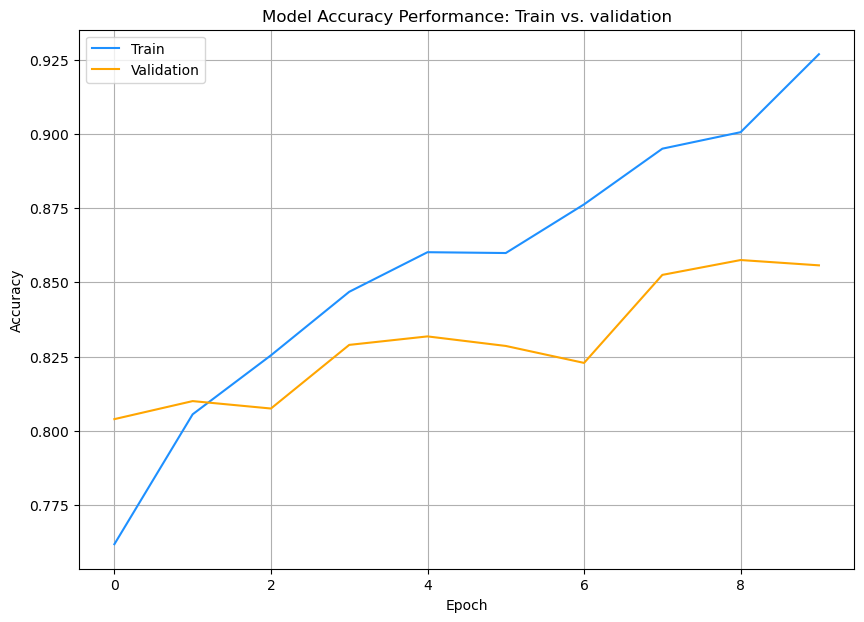

In [33]:
accu = history.history['accuracy']  # Loss data for Training
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [34]:
loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

79/79 [==============================] - 30s 373ms/step


In [36]:
loss, accuracy

(0.3492833375930786, 0.8551999926567078)

In [37]:
model.save('VGG-16_64x64_model.h5')

In [37]:
#Expanding the original dataset from 3000 to 6000 images significantly enhances the machine learning model's performance.
#This increase fosters better generalization, reducing overfitting by exposing the model to a broader range of 
#real-world scenarios. 
#The improved dataset size creates more nuanced feature learning, leading to a notable boost in the model's accuracy.
#Opting for a larger image size like 299x299 pixels with VGG16 can enhance model performance by capturing finer details
#and improving feature extraction, especially in deeper layers. Transfer learning with a pre-trained VGG16 model 
#originally trained on larger images may be advantageous. However, this comes with increased computational costs, 
#longer training times, and potential compatibility issues. The trade-off between improved performance and higher
#computational expenses should be carefully considered through experimentation and validation on the specific task 
#and dataset.